<a href="https://colab.research.google.com/github/Witcape/AI_Practice/blob/main/INCEPTION_CLAHE_FINAL_CROPPED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_dir = "/content/drive/MyDrive/Final_Cropped/Train"
test_dir = "/content/drive/MyDrive/Final_Cropped/Test"

# List all image paths and corresponding labels
image_paths = []
labels = []

for class_dir in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_dir)

    if not os.path.isdir(class_path):
        continue

    for img in os.listdir(class_path):
        image_paths.append(os.path.join(class_path, img))
        labels.append(class_dir)  # Use the directory name as the label

# Split into train and validation
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)


In [6]:
unique_labels = set(labels)
unique_labels
import pandas as pd

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
# Create DataFrame for training data
train_df = pd.DataFrame({
    "filepath": train_paths,
    "class": train_labels
})

# Create DataFrame for validation data
val_df = pd.DataFrame({
    "filepath": val_paths,
    "class": val_labels
})



val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="class",
    target_size=(299, 299),  # Image size for InceptionV3
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="class",
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

Found 846 validated image filenames belonging to 3 classes.
Found 211 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


In [8]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(1024, activation='relu')(x)  # Fully connected layer
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)  # Output layer

model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
for layer in base_model.layers:
    layer.trainable = False

In [11]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
history_fine = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 271s 8s/step - accuracy: 0.4868 - loss: 2.5760 - val_accuracy: 0.7773 - val_loss: 0.5628
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 712ms/step - accuracy: 0.8534 - loss: 0.3662 - val_accuracy: 0.8910 - val_loss: 0.2948
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 732ms/step - accuracy: 0.9048 - loss: 0.2841 - val_accuracy: 0.8910 - val_loss: 0.2816
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 720ms/step - accuracy: 0.8994 - loss: 0.2575 - val_accuracy: 0.8957 - val_loss: 0.2725
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 727ms/step - accuracy: 0.9069 - loss: 0.2086 - val_accuracy: 0.9052 - val_loss: 0.2638
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 718ms/step - accuracy: 0.9051 - loss: 0.2016 - val_accuracy: 0.9242 - val_loss: 0.2692
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 759ms/step - accuracy: 0.9421 - loss: 0.1632 - val_accuracy: 0.8957 - val_loss: 0.2980
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 745ms/step - accuracy: 0.9286 - loss: 0.1863 - val_accuracy: 0.9100 

In [13]:
for layer in base_model.layers[-50:]:
    layer.trainable = True

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
history_fine = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8708 - loss: 0.3037 - val_accuracy: 0.8389 - val_loss: 0.6250
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 50s 732ms/step - accuracy: 0.9493 - loss: 0.1474 - val_accuracy: 0.8768 - val_loss: 0.4357
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 763ms/step - accuracy: 0.9722 - loss: 0.0944 - val_accuracy: 0.9005 - val_loss: 0.3175
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 728ms/step - accuracy: 0.9700 - loss: 0.0686 - val_accuracy: 0.9431 - val_loss: 0.2334
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 741ms/step - accuracy: 0.9736 - loss: 0.0880 - val_accuracy: 0.9526 - val_loss: 0.1787
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 735ms/step - accuracy: 0.9842 - loss: 0.0410 - val_accuracy: 0.9526 - val_loss: 0.1718
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 735ms/step - accuracy: 0.9795 - loss: 0.0497 - val_accuracy: 0.9431 - val_loss: 0.1955
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 726ms/step - accuracy: 0.9854 - loss: 0.0381 - val_accurac

In [16]:
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 128 images belonging to 3 classes.


In [17]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - accuracy: 0.9740 - loss: 0.0675
Test Accuracy: 0.9688


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step


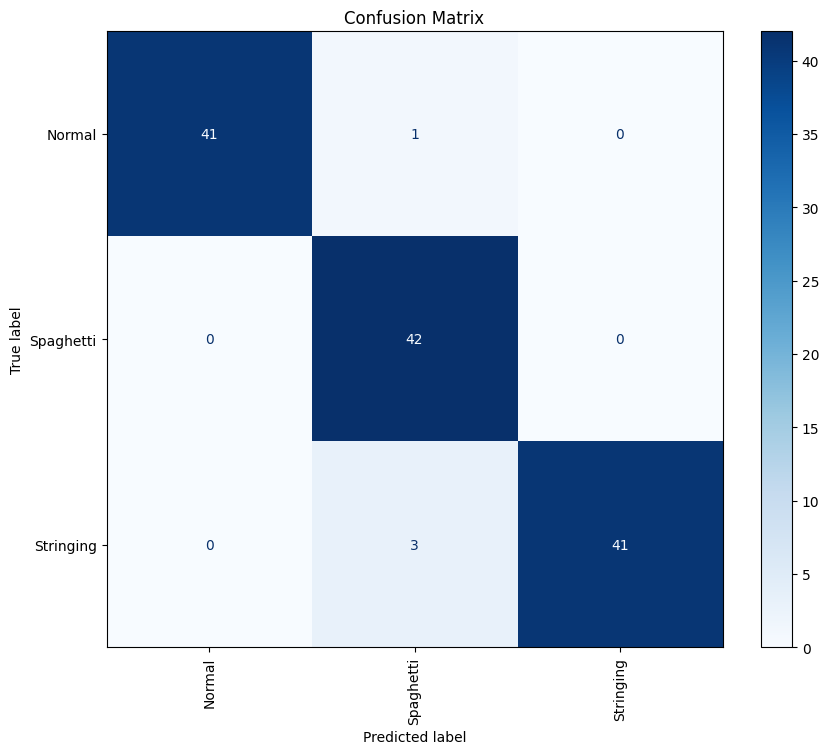

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true_labels = test_generator.classes  # These are the true labels
class_labels = list(test_generator.class_indices.keys())  # Class names

pred_probabilities = model.predict(test_generator)

predicted_labels = np.argmax(pred_probabilities, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation='vertical', ax=plt.gca())
plt.title('Confusion Matrix')
plt.show()
